In [ ]:
import sys
import os

# Add the parent directory to the system path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from pipeline import pipeline_utils
# Import our own modules

pd.set_option('display.max_columns', None)


RAW_DATA_DIR = "data/raw"
PROCESSED_DATA_DIR = "data/preprocessed"
MODEL_OUTPUT_DIR = "data/model_output"

In [2]:
# Load raw data
accounts = pd.read_csv(os.path.join(RAW_DATA_DIR, "accounts.csv"), parse_dates=['start_date'],)
balance_snapshots = pd.read_csv(os.path.join(RAW_DATA_DIR, "balance_snapshots.csv"), parse_dates=['check_date'], keep_default_na=True)
balance_snapshots.insert(0,'snapshot_id', balance_snapshots.index + 1)
balance_snapshots = balance_snapshots.set_index('snapshot_id', drop=False).drop(columns=['delinquency_key'])
bad_debts = pd.read_csv(os.path.join(RAW_DATA_DIR, "bad_debts.csv"), parse_dates=['closing_date'],)

# Basic dimensions
print("Accounts shape:", accounts.shape)
print("Balance Checks shape:", balance_snapshots.shape)
print("Bad Debts shape:", bad_debts.shape)

Accounts shape: (13988, 5)
Balance Checks shape: (580129, 18)
Bad Debts shape: (539, 8)


**Aggregate Data**

In [ ]:
def generate_snapshots_with_aggregated_features(
    snapshots_data,
):
    """
    Generate snapshot features from raw delinquency data.
    """
    aggregated_snapshots_data = snapshots_data.copy()
    aggregated_snapshots_data.fillna({'delinquency_type': 'None'}, inplace=True)
    aggregated_snapshots_data = aggregated_snapshots_data.sort_values(['account_id', 'check_date'])
    aggregated_snapshots_data['check_cycle_number'] = aggregated_snapshots_data.groupby('account_id').cumcount() + 1
    aggregated_snapshots_data['is_delinquent'] = aggregated_snapshots_data['delinquency_type'].isin(['Full', 'Major', 'Partial', 'Minor'])

    def compute_snapshot_cumulative_stats(group):
        result = []
        for idx, row in group.iterrows():
            current_cycle = row['check_cycle_number']
            df_upto = group[group['check_cycle_number'] <= current_cycle]
            streaks = (df_upto['is_delinquent'] != df_upto['is_delinquent'].shift()).cumsum()
            streak_lengths = df_upto.groupby(streaks)['is_delinquent'].agg(['first', 'size'])
            true_streaks = streak_lengths[streak_lengths['first'] == True]['size']
            snapshot = {
                'snapshot_id': row.name,
                'account_id': row['account_id'],
                'check_date': row['check_date'],
                'check_cycle_number': current_cycle,
                'current_balance': row['unpaid_balance'],
                'current_delinquency_score': row['delinquency_score'],
            }
            snapshot.update({
                'is_delinquent': row['is_delinquent'],
                'total_delinquencies': df_upto['is_delinquent'].sum(),
                'count_suspension': (df_upto['account_action'] == 'Suspended Account').sum(),
                'count_actively_delinquent': df_upto['account_action'].isin(['Account Marked Delinquent', 'Account Continued Delinquency']).sum(),
                'max_delinquency_score': df_upto['delinquency_score'].max(),
                'total_penalties': df_upto['delinquency_penalty'].sum(),
                'average_penalty_per_incident': df_upto[df_upto['delinquency_penalty'] > 0]['delinquency_penalty'].mean() or 0,
                'count_streak_1': (true_streaks == 1).sum(),
                'count_streak_2_3': true_streaks[(true_streaks >= 2) & (true_streaks <= 3)].count(),
                'count_streak_4plus': (true_streaks >= 4).sum(),
                'count_full_misses': (df_upto['delinquency_type'] == 'Full').sum(),
                'count_major_misses': (df_upto['delinquency_type'] == 'Major').sum(),
                'count_partial_misses': (df_upto['delinquency_type'] == 'Partial').sum(),
                'count_minor_misses': (df_upto['delinquency_type'] == 'Minor').sum(),
                'rolling_avg_delinquency_score_3m': df_upto['delinquency_score'].tail(3).mean() if len(df_upto) >= 3 else None,
                'rolling_avg_delinquency_score_6m': df_upto['delinquency_score'].tail(6).mean() if len(df_upto) >= 6 else None,
                'rolling_avg_penalty_3m': df_upto['delinquency_penalty'].tail(3).mean() if len(df_upto) >= 3 else None,
                'rolling_avg_penalty_6m': df_upto['delinquency_penalty'].tail(6).mean() if len(df_upto) >= 6 else None,
                'max_delinquency_score_12m': df_upto['delinquency_score'].tail(12).max() if len(df_upto) >= 12 else df_upto['delinquency_score'].max() or 0,
            })
            delinquent_amounts = df_upto[df_upto['is_delinquent']]['unpaid_balance']
            snapshot.update({
                'total_delinquent_amount': delinquent_amounts.sum(),
                'average_delinquent_amount_per_incident': delinquent_amounts.mean() or 0,
                'max_delinquent_amount': delinquent_amounts.max() or 0
            })
            result.append(snapshot)
        return pd.DataFrame(result)

    all_snapshots = (
        aggregated_snapshots_data
        .groupby('account_id', group_keys=False)
        .apply(compute_snapshot_cumulative_stats)
        .reset_index(drop=True)
    )

    final_columns = [
        'snapshot_id', 'account_id', 'check_date', 'check_cycle_number', 'is_delinquent',
        'total_delinquencies', 'count_suspension', 'count_actively_delinquent',
        'max_delinquency_score', 'total_penalties', 'average_penalty_per_incident',
        'count_streak_1', 'count_streak_2_3', 'count_streak_4plus',
        'count_full_misses', 'count_major_misses', 'count_partial_misses', 'count_minor_misses',
        'total_delinquent_amount', 'average_delinquent_amount_per_incident',
        'max_delinquent_amount', 'current_balance', 'current_delinquency_score',
        'rolling_avg_delinquency_score_3m', 'rolling_avg_delinquency_score_6m',
        'rolling_avg_penalty_3m', 'rolling_avg_penalty_6m', 'max_delinquency_score_12m',
    ]
    snapshots_data = all_snapshots[final_columns]
    snapshots_data.fillna({
        'average_penalty_per_incident': 0,
        'average_delinquent_amount_per_incident': 0,
        'max_delinquent_amount': 0,
        'rolling_avg_delinquency_score_3m': 0,
        'rolling_avg_delinquency_score_6m': 0,
        'rolling_avg_penalty_3m': 0,
        'rolling_avg_penalty_6m': 0,
        'max_delinquency_score_12m': 0,
    }, inplace=True)
    return snapshots_data.set_index('snapshot_id', drop=False)



snapshots_data = generate_snapshots_with_aggregated_features(
    snapshots_data=balance_snapshots
)
# snapshots_data.to_csv(os.path.join(PROCESSED_DATA_DIR, "balance_snapshots_aggregated.csv"), index=False)



**Create Flags**

In [ ]:
def annotate_snapshots(balance_snapshots, bad_debts, min_cycle_for_snapshot=6, snapshot_cycle_spacing=3):
    snapshots_data_annotated = balance_snapshots.copy()
    # snapshots_data_annotated['snapshot_id'] = snapshots_data_annotated['snapshot_id']
    snapshots_data_annotated['check_cycle_number'] = snapshots_data_annotated.groupby('account_id').cumcount() + 1
    snapshots_data_annotated['max_check_cycle'] = snapshots_data_annotated.groupby('account_id')['check_cycle_number'].transform('max')
    snapshots_data_annotated['is_final_snapshot'] = snapshots_data_annotated['check_cycle_number'] == snapshots_data_annotated['max_check_cycle']
    snapshots_data_annotated['is_live_snapshot'] = (
        (snapshots_data_annotated['check_cycle_number'] >= min_cycle_for_snapshot) &
        (snapshots_data_annotated['check_cycle_number'] % snapshot_cycle_spacing == 0) &
        (~snapshots_data_annotated['is_final_snapshot'])
    )
    bad_debts_accounts = bad_debts['account_id'].unique()
    mature_accounts = snapshots_data_annotated[snapshots_data_annotated['max_check_cycle'] >= 24]['account_id'].unique()
    snapshots_data_annotated['is_bad_debt_account'] = snapshots_data_annotated['account_id'].isin(bad_debts_accounts)
    snapshots_data_annotated['is_mature_non_bad_debt_account'] = snapshots_data_annotated['account_id'].isin(mature_accounts) & ~snapshots_data_annotated['is_bad_debt_account']
    # snapshots_data_annotated['tobe_labelled'] = snapshots_data_annotated['is_mature_account'] | snapshots_data_annotated['is_bad_debt']
    snapshots_data_annotated = snapshots_data_annotated[[
        'snapshot_id','account_id', 'check_date',
        'check_cycle_number','max_check_cycle', 'is_delinquent', 'is_final_snapshot', 'is_live_snapshot',
        'is_bad_debt_account', 'is_mature_non_bad_debt_account'
        ]].copy()
    return snapshots_data_annotated.set_index('snapshot_id', drop=False)

min_cycle_for_snapshot = 6
snapshot_cycle_spacing = 3
snapshots_data_annotated = annotate_snapshots(balance_snapshots, bad_debts, min_cycle_for_snapshot, snapshot_cycle_spacing)
snapshots_data_annotated

,snapshot_id,account_id,check_date,check_cycle_number,max_check_cycle,is_delinquent,is_final_snapshot,is_live_snapshot,is_bad_debt_account,is_mature_non_bad_debt_account
snapshot_id,,,,,,,,,,
1,1,5b704d10-8488-4d9e-9c33-258c600f0a8a,2020-03-01,1,70,True,False,False,False,True
2,2,0fcb4bfb-c5fa-4c1b-81af-2fcbe9f58919,2020-03-01,1,70,False,False,False,False,True
3,3,529d527c-b759-4791-9d54-4a344049f6b4,2020-03-01,1,70,True,False,False,False,True
4,4,61da90fb-e667-4e76-abdc-3769586f5acd,2020-03-01,1,70,False,False,False,False,True
5,5,1515d293-dca0-4978-93c2-afd5697f5a62,2020-03-01,1,70,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
580125,580125,54738c24-9cf6-4f0c-baaf-489baf0b9a27,2025-10-31,49,49,False,True,False,False,True
580126,580126,ed7e7b1e-66f7-4af2-a0ad-bd5a53a47e35,2025-10-31,30,30,True,True,False,False,True
580127,580127,88efec7f-8d84-46f5-82b4-2f29aa172bc0,2025-10-31,70,70,False,True,False,False,True


**Normalize**

In [ ]:
def normalize_snapshot_features_by_cycles(
    snapshots_data,
    norm_features,
    non_norm_features
):
    features_df = snapshots_data[norm_features].copy()
    account_age = features_df.pop('check_cycle_number').clip(lower=1)
    features_df_cycl_norm = features_df.div(account_age, axis=0)
    features_df_cycl_norm.rename(columns={col: f"{col}_norm" for col in features_df.columns}, inplace=True)
    result = pd.concat([snapshots_data[non_norm_features], features_df_cycl_norm], axis=1)
    return result


norm_features = [
    'check_cycle_number','total_delinquencies', 'count_suspension', 'count_actively_delinquent',
    'total_penalties', 'count_streak_1', 'count_streak_2_3',
    'count_streak_4plus', 'count_full_misses', 'count_major_misses',
    'count_partial_misses', 'count_minor_misses'
]

non_norm_features = [
    'check_cycle_number', 'max_delinquency_score', 'average_penalty_per_incident',
]

snapshots_data_normalized = normalize_snapshot_features_by_cycles(
    snapshots_data=snapshots_data,
    norm_features=norm_features,
    non_norm_features=non_norm_features
)
# snapshots_data_normalized.to_csv(os.path.join(PROCESSED_DATA_DIR, "balance_snapshots_features.csv"), index=True)
snapshots_data_normalized

**Label**

In [24]:
import warnings
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")

def label_data(final_snapshots_features,final_snapshots_meta):
    final_snapshots_features_copy = final_snapshots_features.copy().drop(columns=['check_cycle_number'])
    final_snapshots_meta_copy = final_snapshots_meta.copy()

    # Transform the features for clustering
    X = final_snapshots_features_copy
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_indexed = pd.DataFrame(X_scaled, index=final_snapshots_features_copy.index, columns=X.columns)
    
    # Identify candidates for A, B, and C labels and determine their centroids
    # C: Bad Debt Accounts 
    C_candidates = final_snapshots_meta_copy[final_snapshots_meta_copy['is_bad_debt_account']].index
    X_C_candidates = X_scaled_indexed.loc[C_candidates]
    centroid_C = X_C_candidates.mean(axis=0) if len(X_C_candidates) > 0 else np.zeros(X.shape[1])

    # A: Mature Clean Non-Bad Debt Accounts and 
    AB_candidates = final_snapshots_meta_copy[final_snapshots_meta_copy['is_mature_non_bad_debt_account']].index
    X_AB_candidates = X_scaled_indexed.loc[AB_candidates]
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConvergenceWarning)
            kmeans_A = KMeans(n_clusters=2, random_state=42)
            A_clusters = kmeans_A.fit_predict(X_AB_candidates)
        cluster0_mean = X_AB_candidates[A_clusters == 0].mean(axis=0)
        cluster1_mean = X_AB_candidates[A_clusters == 1].mean(axis=0)
        A_cluster_id = 0 if cluster0_mean[0] < cluster1_mean[0] else 1
        A_candidates = AB_candidates[A_clusters == A_cluster_id]
        centroid_A = kmeans_A.cluster_centers_[A_cluster_id]
    except Exception as e:
        print(f"[Warning] KMeans clustering in hybrid_labelling failed: {e}")
        # Fallback: assign all non-bad-debt to A
        A_candidates = AB_candidates[AB_candidates].index
        centroid_A = X_AB_candidates.mean(axis=0) if len(X_AB_candidates) > 0 else np.zeros(X.shape[1])

    # B: Mature Risky Non-Bad Debt Accounts
    B_candidates = final_snapshots_features_copy.index.difference(A_candidates.union(C_candidates))
    X_B_candidates = X_scaled_indexed.loc[B_candidates]
    centroid_B = X_B_candidates.mean(axis=0) if len(X_B_candidates) > 0 else np.zeros(X.shape[1])

    dist_to_A = cdist(X_B_candidates, [centroid_A]).flatten() if len(X_B_candidates) > 0 else np.array([])
    dist_to_C = cdist(X_B_candidates, [centroid_C]).flatten() if len(X_B_candidates) > 0 else np.array([])
    dist_to_B = cdist(X_B_candidates, [centroid_B]).flatten() if len(X_B_candidates) > 0 else np.array([])

    # Reclassify B candidates based on distances to A, B, and C centroids
    max_delinquency_scores = final_snapshots_features_copy.loc[B_candidates]['max_delinquency_score'].values if len(X_B_candidates) > 0 else np.array([])
    B_candidates_labels = {}
    for idx, (a, b, c), max_score in zip(B_candidates, zip(dist_to_A, dist_to_B, dist_to_C), max_delinquency_scores):
        if b < a and b < c:
            B_candidates_labels[idx] = 'B'
        elif a < c:
            if max_score <= 6:
                B_candidates_labels[idx] = 'A'
            else:
                B_candidates_labels[idx] = 'B'
        else:
            if max_score >= 8:
                B_candidates_labels[idx] = 'C'
            else:
                B_candidates_labels[idx] = 'B'

    # Create a Series to hold the hybrid labels
    labels = pd.concat([
        pd.Series(index=A_candidates, data='A', dtype='object'),
        pd.Series(index=C_candidates, data='C', dtype='object'),
        pd.Series(B_candidates_labels,dtype='object')
    ]).rename('label')
    return labels

final_snapshots_tobe_labelled = snapshots_data_normalized[
    snapshots_data_annotated['is_final_snapshot'] &
    (snapshots_data_annotated['is_mature_non_bad_debt_account'] |
    snapshots_data_annotated['is_bad_debt_account'])
].copy()
final_snapshots_meta = snapshots_data_annotated[
    snapshots_data_annotated['is_final_snapshot'] &
    (snapshots_data_annotated['is_mature_non_bad_debt_account'] |
    snapshots_data_annotated['is_bad_debt_account'])
].copy()

final_snapshots_labels = label_data(final_snapshots_tobe_labelled, final_snapshots_meta)
final_snapshots_labels = pd.concat([
    final_snapshots_labels,
    final_snapshots_meta['account_id']
], axis=1)
snapshots_data_annotated = snapshots_data_annotated.merge(
    final_snapshots_labels,
    on='account_id',
    how='left'
).set_index('snapshot_id', drop=False).fillna({'label': 'X'})
snapshots_data_annotated['is_labelled'] = snapshots_data_annotated['label'] != 'X'
snapshots_data_annotated

,snapshot_id,account_id,check_date,check_cycle_number,max_check_cycle,is_delinquent,is_final_snapshot,is_live_snapshot,is_bad_debt_account,is_mature_non_bad_debt_account,label,is_labelled
snapshot_id,,,,,,,,,,,,
1,1,5b704d10-8488-4d9e-9c33-258c600f0a8a,2020-03-01,1,70,True,False,False,False,True,B,True
2,2,0fcb4bfb-c5fa-4c1b-81af-2fcbe9f58919,2020-03-01,1,70,False,False,False,False,True,A,True
3,3,529d527c-b759-4791-9d54-4a344049f6b4,2020-03-01,1,70,True,False,False,False,True,A,True
4,4,61da90fb-e667-4e76-abdc-3769586f5acd,2020-03-01,1,70,False,False,False,False,True,A,True
5,5,1515d293-dca0-4978-93c2-afd5697f5a62,2020-03-01,1,70,False,False,False,False,True,B,True
...,...,...,...,...,...,...,...,...,...,...,...,...
580125,580125,54738c24-9cf6-4f0c-baaf-489baf0b9a27,2025-10-31,49,49,False,True,False,False,True,A,True
580126,580126,ed7e7b1e-66f7-4af2-a0ad-bd5a53a47e35,2025-10-31,30,30,True,True,False,False,True,A,True
580127,580127,88efec7f-8d84-46f5-82b4-2f29aa172bc0,2025-10-31,70,70,False,True,False,False,True,A,True


In [25]:
snapshots_data_annotated.value_counts('label').sort_index()

label
A    280828
B    224489
C     35930
X     38882
Name: count, dtype: int64

**Identify Train Val Test Splits Index**

In [ ]:
import pandas as pd
import numpy as np
import argparse
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_size=0.7
val_size=0.15
test_size=0.15
random_state=42
# Identify final snapshots, live snapshots, and unlabelled snapshots


final_snapshots_labels = snapshots_data_annotated[snapshots_data_annotated['is_final_snapshot']
                                                  & snapshots_data_annotated['is_labelled']]['label']
live_snapshots_labels = snapshots_data_annotated[snapshots_data_annotated['is_live_snapshot']
                                                 & snapshots_data_annotated['is_labelled']]['label']


all_account_ids = snapshots_data_annotated.loc[final_snapshots_labels.index,"account_id"].unique()
# # First split into train and temp (val+test)
account_ids_train, account_ids_temp, labels_train, labels_temp = train_test_split(
    all_account_ids, final_snapshots_labels, stratify=final_snapshots_labels, 
    test_size=(1-train_size), random_state=random_state
)
# # Now split temp into val and test
val_relative = val_size / (val_size + test_size)
account_ids_val, account_ids_test, labels_val, labels_test = train_test_split(
    account_ids_temp, labels_temp, stratify=labels_temp,
    test_size=(1-val_relative), random_state=random_state
)
snapshots_data_annotated['purpose'] = 'unused'
snapshots_data_annotated.loc[snapshots_data_annotated['account_id'].isin(account_ids_train)
                            & (snapshots_data_annotated['is_live_snapshot'])
                            & (snapshots_data_annotated['is_labelled']), 'purpose'] = 'train'
snapshots_data_annotated.loc[snapshots_data_annotated['account_id'].isin(account_ids_val)
                            & (snapshots_data_annotated['is_live_snapshot'])
                            & (snapshots_data_annotated['is_labelled']), 'purpose'] = 'val'
snapshots_data_annotated.loc[snapshots_data_annotated['account_id'].isin(account_ids_test)
                            & (snapshots_data_annotated['is_live_snapshot'])
                            & (snapshots_data_annotated['is_labelled']), 'purpose'] = 'test'
snapshots_data_annotated.loc[snapshots_data_annotated['check_cycle_number'] < min_cycle_for_snapshot, 'purpose'] = 'unqualified'
# Add final labels
snapshots_data_annotated.loc[final_snapshots_labels.index, 'purpose'] = 'final_label'
# snapshots_data_annotated.to_csv(os.path.join(PROCESSED_DATA_DIR, "balance_snapshots_annotated.csv"), index=False)
snapshots_data_annotated

In [27]:
snapshots_data_annotated['purpose'].value_counts()

purpose
unused         339141
train          114439
unqualified     67040
val             24657
test            24426
final_label     10426
Name: count, dtype: int64

**Train and Predict**

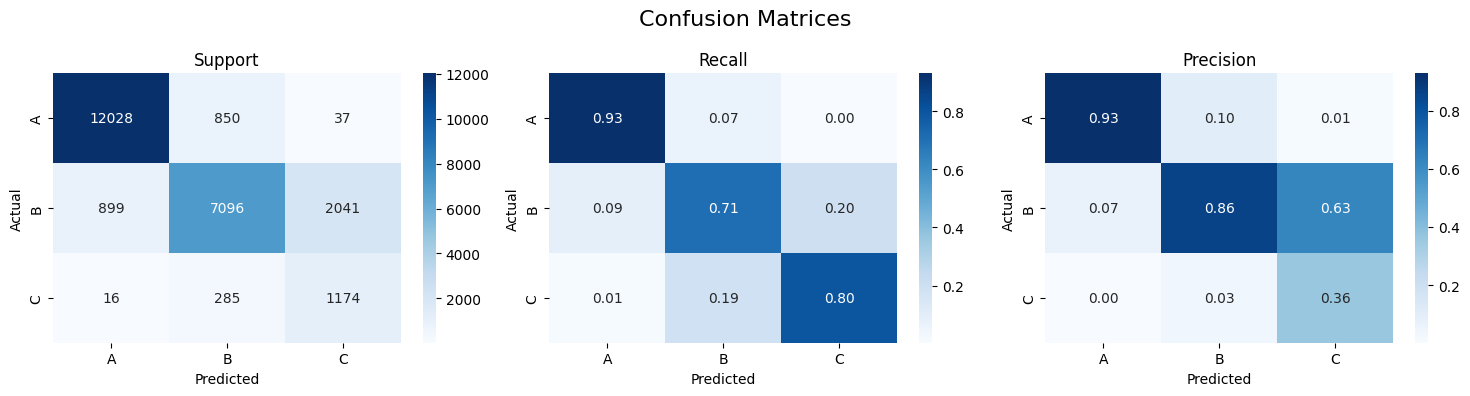

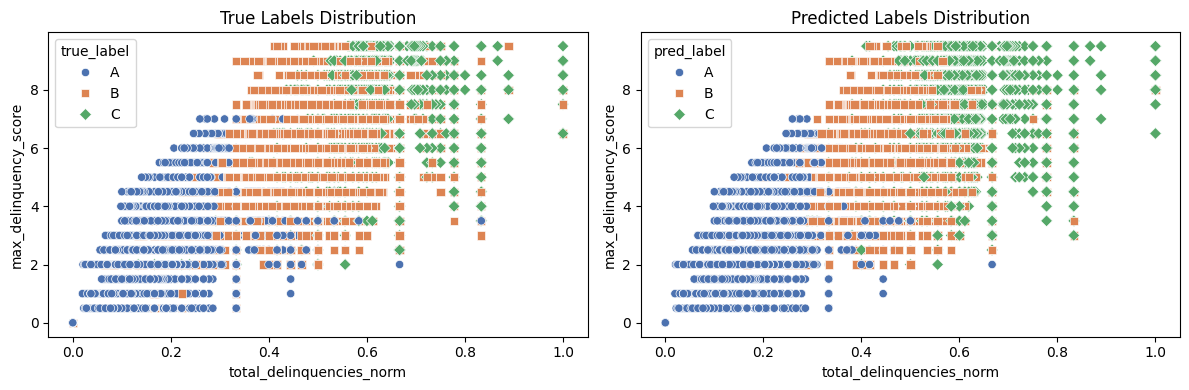

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

train_split = snapshots_data_annotated[snapshots_data_annotated['purpose'] == 'train'].index
val_split = snapshots_data_annotated[snapshots_data_annotated['purpose'] == 'val'].index
test_split = snapshots_data_annotated[snapshots_data_annotated['purpose'] == 'test'].index

train_features = snapshots_data_normalized.loc[train_split]
val_features = snapshots_data_normalized.loc[val_split]
test_features = snapshots_data_normalized.loc[test_split]

train_labels = snapshots_data_annotated.loc[train_split, 'label']
val_labels = snapshots_data_annotated.loc[val_split, 'label']
test_labels = snapshots_data_annotated.loc[test_split, 'label']

# train_split
# snapshots_data_normalized.loc[train_split]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)
X_val_scaled = scaler.transform(val_features)

rus = RandomUnderSampler(random_state=42 ,replacement=True)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, train_labels)

# # Train and evaluate classifier on resampled data
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_resampled, y_train_resampled)
y_pred = model_rf.predict(X_test_scaled)

# Evaluate the model

test_labels_df = test_labels.copy().rename('true_label').to_frame()
test_labels_df['pred_label'] = y_pred
test_labels_df['P[A]'] = model_rf.predict_proba(X_test_scaled)[:, 0].round(3)
test_labels_df['P[B]'] = model_rf.predict_proba(X_test_scaled)[:, 1].round(3)
test_labels_df['P[C]'] = model_rf.predict_proba(X_test_scaled)[:, 2].round(3)
test_labels_df
test_labels_df = pd.concat([test_features, test_labels_df], axis=1)
plot.plot_confusion_matrices(test_labels, y_pred, class_labels=['A', 'B', 'C'], figsize=(15, 4))
plt.tight_layout()
plot.plot_true_vs_predictions(test_labels_df, 'true_label', 'pred_label', 
                         x='total_delinquencies_norm', y='max_delinquency_score', figsize=(12, 4))
plt.tight_layout()

**Prediction Results on All**

In [29]:
all_qualified_snapshots = snapshots_data_annotated[snapshots_data_annotated['purpose'] != 'unqualified']
all_qualified_snapshots_features = snapshots_data_normalized.loc[all_qualified_snapshots.index]

# Predictions for all qualified snapshots
all_qualified_snapshots_features_scaled = scaler.transform(all_qualified_snapshots_features)
all_qualified_snapshots_predictions = model_rf.predict(all_qualified_snapshots_features_scaled)
all_qualified_snapshots_predictions_proba = model_rf.predict_proba(all_qualified_snapshots_features_scaled)

all_qualified_snapshots_predictions = pd.DataFrame({
    'pred_label': all_qualified_snapshots_predictions,
    'P[A]': all_qualified_snapshots_predictions_proba[:, 0].round(3),
    'P[B]': all_qualified_snapshots_predictions_proba[:, 1].round(3),
    'P[C]': all_qualified_snapshots_predictions_proba[:, 2].round(3),
}, index=all_qualified_snapshots_features.index)

all_qualified_snapshots_predictions.to_csv(os.path.join(MODEL_OUTPUT_DIR, "balance_snapshots_predictions.csv"), index=True) 

**Global Feature Importances**

100%|===================| 14993/15000 [14:46<00:00]        

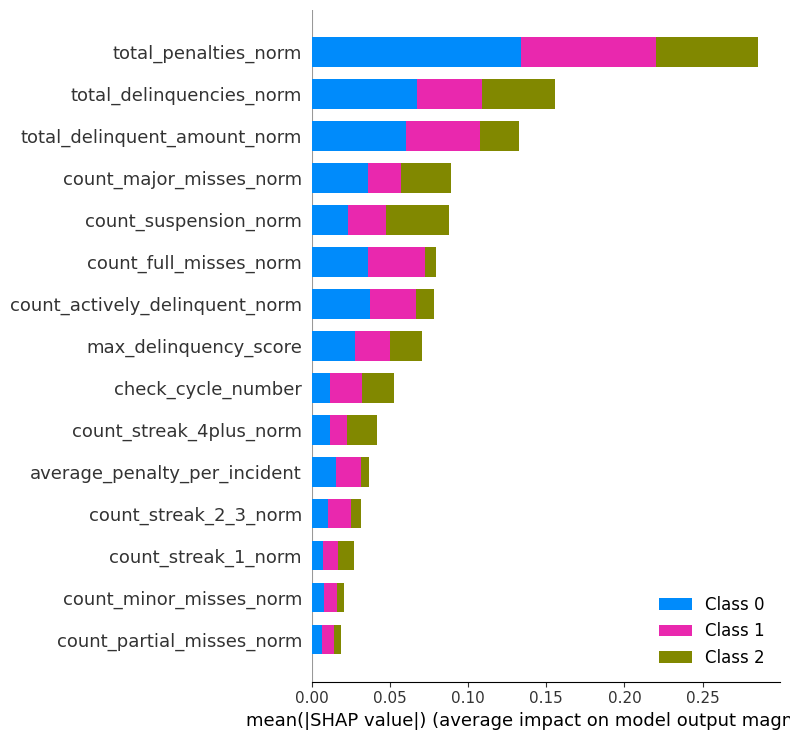

In [19]:
import shap


def plot_shap_global_importance(
    model,
    X_background,
    X_explain,
    shap_values=None,
    use_shap_summary=True,
    top_n=10,
    plot_type='bar',
    title='Global SHAP Feature Importance'
):
    """
    Plots global SHAP feature importance using either custom bar chart or SHAP summary plot.

    Parameters:
    - model: Trained model
    - X_background: Background dataset for TreeExplainer
    - X_explain: Dataset to compute SHAP values
    - shap_values: (optional) Precomputed SHAP values (speeds things up)
    - use_shap_summary: If True, use SHAP's built-in summary plot
    - top_n: Number of top features to display
    - plot_type: 'bar' or 'dot' (used only for SHAP summary)
    - title: Title for custom plot
    """

    explainer = shap.TreeExplainer(model, data=X_background)

    if shap_values is None:
        shap_values = explainer.shap_values(X_explain, check_additivity=False)

    # Handle multiclass (returns list of arrays)
    if isinstance(shap_values, list):
        combined_shap = sum([abs(class_vals) for class_vals in shap_values])
        mean_abs_shap = combined_shap.mean(axis=0)
    else:
        mean_abs_shap = abs(shap_values).mean(axis=0)

    if use_shap_summary:
        # SHAP summary plot with dot or bar option
        shap.summary_plot(shap_values, X_explain, plot_type=plot_type, max_display=top_n,)
    else:
        # Custom horizontal bar chart
        importances = pd.DataFrame({
            'feature': X_explain.columns,
            'mean_abs_shap': mean_abs_shap
        }).sort_values(by='mean_abs_shap', ascending=False).head(top_n)

        plt.figure(figsize=(10, 6))
        plt.barh(importances['feature'][::-1], importances['mean_abs_shap'][::-1])
        plt.xlabel("Mean |SHAP value|")
        plt.title(title)
        plt.tight_layout()
        plt.show()

plot_shap_global_importance(
    model=model_rf,
    X_background=pd.DataFrame(X_train_resampled, 
                              columns=train_features.columns).sample(5000, random_state=42),
    X_explain=pd.DataFrame(X_test_scaled, 
                           columns=test_features.columns).sample(5000, random_state=42),
    shap_values=None,
    use_shap_summary=True,
    top_n=20,
    plot_type='bar',
    title='Global SHAP Feature Importance for Random Forest Classifier'
)

**Local Feature Importance**

In [33]:
def add_shap_local_importance(
    model, 
    X_background, 
    dataset_to_explain, 
    labels,
    top_n=3,
    original_dataset=None,

):
    """
    Adds top SHAP local feature importances to a dataset for each instance.

    Parameters:
    - model: Trained model to explain
    - X_background: Background dataset for SHAP explainer
    - dataset_to_explain: DataFrame containing rows to explain and prediction info
    - feature_columns: List of feature columns used for prediction
    - label_col: Column name for predicted class (default 'predicted_label')
    - top_n: Number of top features to include (default 3)

    Returns:
    - dataset_to_explain: Original DataFrame with added "shap_top_features" column
    """

    def get_shap_local_importance(explainer, X_instance, class_index=1, top_n=3):
        shap_vals = explainer.shap_values(X_instance, check_additivity=False)
        values = shap_vals[0][:, class_index]
        feature_names = X_instance.columns
        importance = sorted(zip(feature_names, values), key=lambda x: abs(x[1]), reverse=True)
        return importance[:top_n]

    explainer = shap.TreeExplainer(model, data=X_background)
    top_features_list = []

    for i, row in dataset_to_explain.iterrows():
        pred_class = labels.iloc[i]
        X_instance = row.to_frame().T
        class_index = ['A', 'B', 'C'].index(pred_class) if isinstance(pred_class, str) else pred_class
        top_feats = get_shap_local_importance(explainer, X_instance, class_index=class_index, top_n=top_n)
        top_features_list.append(
            pd.concat([pd.DataFrame([{'snapshot_id': row.name,
                **{
                    'feature_rank': j + 1,
                    'feature_name': f[0],
                    'feature_value': original_dataset.iloc[i][f[0]] if original_dataset is not None else row[f[0]],
                    'shap_value': f[1],
                    'effect': 'Promoting Class Likelihood' if f[1] > 0 else 'Demoting Class Likelihood',
                    'predicted_label': pred_class,
                }
            }]) for j, f in enumerate(top_feats)])
        )

    top_features_list = pd.concat(top_features_list)
    return top_features_list

test_snapshots_predictions_with_shap = add_shap_local_importance(
    model=model_rf,
    X_background=pd.DataFrame(X_train_resampled, 
                              columns=train_features.columns),
    dataset_to_explain=pd.DataFrame(X_test_scaled, 
                                    columns=test_features.columns).sample(200, random_state=42),
    labels = test_labels_df['pred_label'],
    top_n=5,
    original_dataset=test_features,

)
test_snapshots_predictions_with_shap

,snapshot_id,feature_rank,feature_name,feature_value,shap_value,effect,predicted_label
0,19444,1,total_penalties_norm,0.333333,0.181899,Promoting Class Likelihood,A
0,19444,2,count_major_misses_norm,0.000000,0.077464,Promoting Class Likelihood,A
0,19444,3,average_penalty_per_incident,1.000000,0.070858,Promoting Class Likelihood,A
0,19444,4,max_delinquency_score,1.000000,0.069407,Promoting Class Likelihood,A
0,19444,5,count_full_misses_norm,0.000000,0.068134,Promoting Class Likelihood,A
...,...,...,...,...,...,...,...
0,16325,1,total_delinquencies_norm,0.222222,0.086845,Promoting Class Likelihood,A
0,16325,2,total_penalties_norm,0.444444,0.061763,Promoting Class Likelihood,A
0,16325,3,max_delinquency_score,2.000000,0.046488,Promoting Class Likelihood,A
0,16325,4,count_suspension_norm,0.000000,0.039743,Promoting Class Likelihood,A


**Extract Prediction Explanation for *Most Recent* Snapshots (later than 2025 April)**

In [ ]:
all_qualified_snapshots_live_final_predictions = all_qualified_snapshots_predictions[
    (snapshots_data_annotated['is_final_snapshot'] | snapshots_data_annotated['is_live_snapshot'])
    & (snapshots_data_annotated['check_date'] >= pd.Timestamp('2025-04-01'))
]


model=model_rf
X_background=pd.DataFrame(X_train_resampled,
                            columns=train_features.columns).sample(5000, random_state=42)
dataset_to_explain=pd.DataFrame(all_qualified_snapshots_live_final_predictions,
                                columns=all_qualified_snapshots_features.columns)
labels = all_qualified_snapshots_live_final_predictions['pred_label']
top_n=5
original_dataset = snapshots_data_normalized.loc[all_qualified_snapshots_live_final_predictions.index]


def get_shap_local_importance(explainer, X_instance, class_index=1, top_n=3):
    shap_vals = explainer.shap_values(X_instance, check_additivity=False)
    values = shap_vals[0][:, class_index]
    feature_names = X_instance.columns
    importance = sorted(zip(feature_names, values), key=lambda x: abs(x[1]), reverse=True)
    return importance[:top_n]

explainer = shap.TreeExplainer(model, data=X_background)
top_features_list = []

for i, row in dataset_to_explain.iterrows():
    pred_class = labels.loc[i]
    X_instance = row.to_frame().T
    class_index = ['A', 'B', 'C'].index(pred_class) if isinstance(pred_class, str) else pred_class
    top_feats = get_shap_local_importance(explainer, X_instance, class_index=class_index, top_n=top_n)
    top_features_list.append(
        pd.concat([pd.DataFrame([{'snapshot_id': row.name,
            **{
                'feature_rank': j + 1,
                'feature_name': f[0],
                'feature_value': original_dataset.loc[i][f[0]] if original_dataset is not None else row[f[0]],
                'shap_value': f[1],
                'effect': 'Promoting Class Likelihood' if f[1] > 0 else 'Demoting Class Likelihood',
                'predicted_label': pred_class,
            }
        }]) for j, f in enumerate(top_feats)])
    )

top_features_list = pd.concat(top_features_list)
all_qualified_snapshots_live_final_predictions_with_shap = top_features_list
# all_qualified_snapshots_live_final_predictions_with_shap.to_csv(os.path.join(MODEL_OUTPUT_DIR, "balance_snapshots_predictions_with_shap.csv"), index=False)
all_qualified_snapshots_live_final_predictions_with_shap
